<a href="https://colab.research.google.com/github/HenriqueCCdA/bootCampAluraDataScience/blob/master/modulo3/desafios/Desafio_aula4_modulo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#1) Pre-analise
---

---
## 1.1) Bibliotecas
---

In [22]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

---
#1.2) Funções de apoio
---

In [74]:
def treino_teste(dados: pd.DataFrame , n: int, coluna: str) -> (pd.DataFrame, pd.DataFrame):
  '''
  -------------------------------------------------
  Divide o dados em um DataFrame de treino e teste
  -------------------------------------------------
  @param dados - DataFrame com todo os dados
  @param n - numero de termo no dataframe de treino
  @param colunas - nome da coluna 
  -------------------------------------------------
  @return retorna do df_treino, df_teste
  -------------------------------------------------
  '''
  df_treino = pd.DataFrame()
  df_treino['ds'] = dados['datahora'][:n]
  df_treino['y'] = dados[coluna][:n]

  df_teste = pd.DataFrame()
  df_teste['ds'] = dados['datahora'][n:]
  df_teste['y'] = dados[coluna][n:]

  return df_treino, df_teste

def treinamento(periodo: int ,
                df_treino: pd.DataFrame,
                cps: int = 0.05,
                sm: str = '+',
                feriados= None):
  '''
  -------------------------------------------------
  Treina o modelo
  -------------------------------------------------
  @param periodo - quantidade de pontos previstos
  @param df_treino - dataframe de treino
  @param cps - changepoint_prior_scale 
  @param sm - seasonality_mode
  @param feriados - lista com os feriados
  -------------------------------------------------
  @return retorna o modelo e a previsao
  -------------------------------------------------
  '''
  msm = {"+":"additive",
        "*":"multiplicative"}


  modelo = Prophet(changepoint_prior_scale=cps,
                   seasonality_mode=msm[sm],
                   holidays=feriados,
                   ) 


  modelo.fit(df_treino)
  df_futuro = modelo.make_future_dataframe(periods=periodo)
  previsao = modelo.predict(df_futuro)

  print(f'Numero de datas : {previsao.shape[0]}')

  return modelo, previsao 


## 1.3) Preparando os dados

In [73]:
feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]


feriados_sp_2020 = pd.DataFrame({'holiday': 'sp_2020', 
                                 'ds'     : pd.to_datetime(feriados_sp_2020)}
                                )

feriados_sp_2021 = pd.DataFrame({'holiday': 'sp_2021', 
                                 'ds'     : pd.to_datetime(feriados_sp_2021)}
                                )

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021))

In [11]:
uri = "https://raw.githubusercontent.com/HenriqueCCdA/bootCampAluraDataScience/master/modulo3/dados/dados_covid_sp.csv"

dados = pd.read_csv(uri, sep=";")

dados["datahora"] = pd.to_datetime(dados["datahora"], format="%Y-%m-%d")

dados_sp = dados.query('nome_munic == "São Paulo"').copy()

In [12]:
dados_sp.shape

(443, 26)

# 2) Desafios

---
## 2.1) Desafio 11: Identificar potenciais changepoints.
---


## Sem feriados

In [75]:
df_treino, df_teste = treino_teste(dados_sp, 400, 'casos_novos')
modelo_add, previsao_add = treinamento(43, df_treino, cps=10.0, sm = '+')
modelo_mult, previsao_mult = treinamento(43, df_treino, cps=10.0, sm = '*')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Numero de datas : 443
Numero de datas : 443


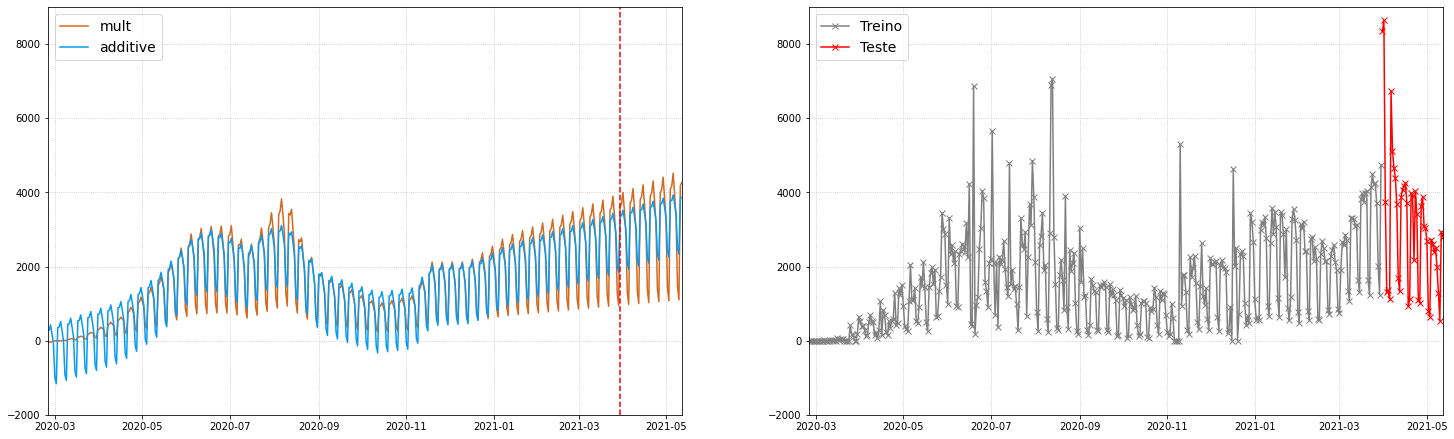

In [142]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize=(25,7.5))

limete_treino = df_treino.iloc[-1][0]

axs[0].plot(previsao_mult['ds'], previsao_mult['yhat'], label = 'mult', color='#D2691E')
axs[0].plot(previsao_add['ds'], previsao_add['yhat']  , label = 'additive', color='#069AF3')

axs[1].plot(df_treino['ds'], df_treino['y'], label = 'Treino', ls='-', marker='x', color='gray')
axs[1].plot(df_teste['ds'], df_teste['y'], label = 'Teste', ls='-', marker='x', color='red')

axs[0].axvline(limete_treino, color ='r', ls="--")

for ax in axs:
  ax.set_xlim(previsao_add.iloc[0][0], previsao_add.iloc[-1][0])
  ax.set_ylim(-2000, 9000)
  ax.legend(fontsize=14)
  ax.grid(ls=':', color='silver')

plt.show()

> Aparentemente o **multiplicatico** se ajustou melhor aos dados

In [112]:
def avalia_metrica(metrica, treino, teste, previsao, n = 400):
  '''
  @param matrica  - a função que calcula a metrica
  @param treino   - DataFrame de treino
  @param teste    - DataFrame de teste
  @param previsao - DataFrame de previsao
  @param n        - numero de dados para treino
  '''
  print("Treino = {:.2e}".format(metrica(treino['y'], previsao['yhat'][:n])))
  print("Teste  = {:.2e}".format(metrica(teste['y'], previsao['yhat'][n:])))

In [118]:
from sklearn.metrics import mean_absolute_error as metrica

print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('Add')
avalia_metrica(metrica, df_treino, df_teste, previsao_add)

Mult
Treino = 4.55e+02
Teste  = 9.11e+02
Add
Treino = 5.40e+02
Teste  = 1.16e+03


In [129]:
from sklearn.metrics import mean_squared_error as metrica

print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('Add')
avalia_metrica(metrica, df_treino, df_teste, previsao_add)

Mult
Treino = 5.26e+05
Teste  = 1.96e+06
Add
Treino = 6.11e+05
Teste  = 2.41e+06


In [130]:
from sklearn.metrics import median_absolute_error as metrica

print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('Add')
avalia_metrica(metrica, df_treino, df_teste, previsao_add)

Mult
Treino = 2.72e+02
Teste  = 5.63e+02
Add
Treino = 3.92e+02
Teste  = 9.63e+02


* **Treino**

metrica                |  mult    |  add
---------------------- |--------- | --------
mean_absolute_error    |4.55e+02  |  5.40e+02
mean_squared_error     |5.26e+05  |  6.11e+05
median_absolute_error  |2.72e+02  |  3.92e+02

* **Teste**

metrica                |  mult    |  add
---------------------- |--------- | --------
mean_absolute_error    |9.11e+02  |  1.16e+03
mean_squared_error     |1.96e+06  |  2.41e+06
median_absolute_error  |5.63e+02  |  9.63e+02

> Em todos os casos o **"multiplicative"** gerou melhores resultados



## Comparando o **"multiplicative"** com e sem feriados

In [131]:
modelo_mult_f, previsao_mult_f = treinamento(43, df_treino, cps=10.0, sm = '*', feriados=feriados)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Numero de datas : 443


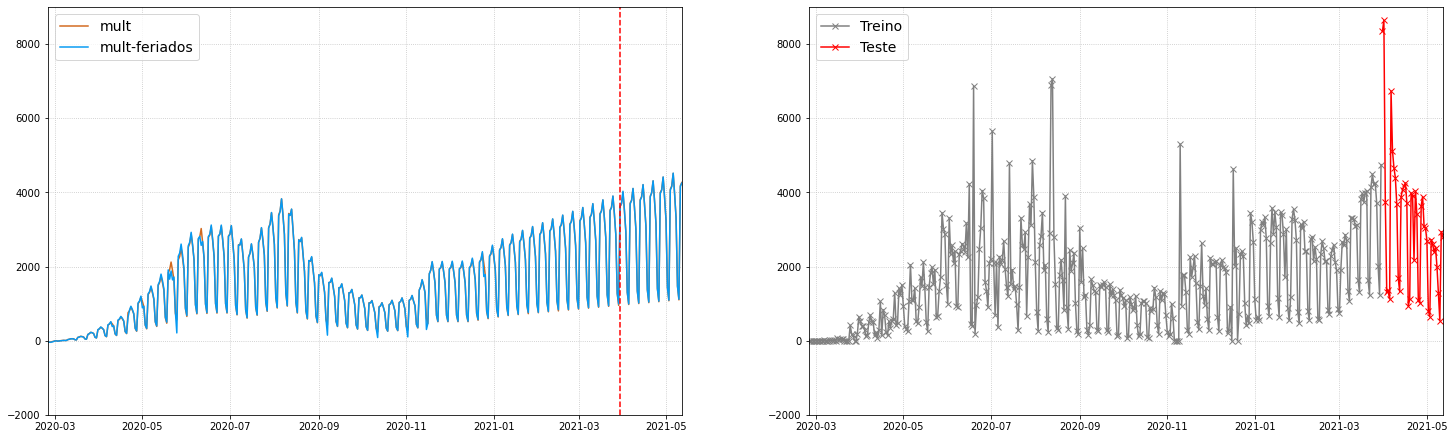

In [143]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize=(25,7.5))

limete_treino = df_treino.iloc[-1][0]

axs[0].plot(previsao_mult['ds'], previsao_mult['yhat'], label = 'mult', color='#D2691E')
axs[0].plot(previsao_mult_f['ds'], previsao_mult_f['yhat']  , label = 'mult-feriados', color='#069AF3')

axs[1].plot(df_treino['ds'], df_treino['y'], label = 'Treino', ls='-', marker='x', color='gray')
axs[1].plot(df_teste['ds'], df_teste['y'], label = 'Teste', ls='-', marker='x', color='red')

axs[0].axvline(limete_treino, color ='r', ls="--")

for ax in axs:
  ax.set_xlim(previsao_mult.iloc[0][0], previsao_mult.iloc[-1][0])
  ax.set_ylim(-2000, 9000)
  ax.legend(fontsize=14)
  ax.grid(ls=':', color='silver')

plt.show()

> O **multiplicatico com feriados** tem pequenas diferenças do **multiplicatico sem feriados**

In [139]:
from sklearn.metrics import mean_absolute_error as metrica

print('mean_absolute_error')
print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('\nMult-Feriados')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult_f)

from sklearn.metrics import mean_squared_error as metrica

print('\nmean_squared_error')
print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('\nMult-Feriados')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult_f)

from sklearn.metrics import median_absolute_error as metrica

print('\nmedian_absolute_error')
print('Mult')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult)
print('\nMult-Feriados')
avalia_metrica(metrica, df_treino, df_teste, previsao_mult_f)

mean_absolute_error
Mult
Treino = 4.55e+02
Teste  = 9.11e+02

Mult-Feriados
Treino = 4.52e+02
Teste  = 9.10e+02

mean_squared_error
Mult
Treino = 5.26e+05
Teste  = 1.96e+06

Mult-Feriados
Treino = 5.23e+05
Teste  = 1.95e+06

median_absolute_error
Mult
Treino = 2.72e+02
Teste  = 5.63e+02

Mult-Feriados
Treino = 2.69e+02
Teste  = 5.62e+02


* **Treino**

metrica                |  mult    |  mult-fev
---------------------- |--------- | --------
mean_absolute_error    |4.55e+02  |  4.52e+02
mean_squared_error     |5.26e+05  |  5.23e+05
median_absolute_error  |2.72e+02  |  2.69e+02

* **Teste**

metrica                |  mult    |  mult-fev
---------------------- |--------- | --------
mean_absolute_error    |9.11e+02  |  9.10e+02
mean_squared_error     |1.96e+06  |  1.95e+06
median_absolute_error  |5.63e+02  |  5.62e+02

> A utilização do ferias gerou **pequenas melhorias** no resultados